In [1]:
import os
import time # optional 
import pandas as pd
import numpy as np
import openai
from openai.embeddings_utils import get_embedding, cosine_similarity
from transformers import GPT2TokenizerFast
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pinecone # for vector database

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
openai.api_key = os.getenv("OPENAI_API_KEY")

In [4]:
input_datapath = './data/Reviews.csv'  # This dataset includes 500k reviews 
df = pd.read_csv(input_datapath, index_col=0)
df = df[['Time', 'ProductId', 'UserId', 'Score', 'Summary', 'Text']]
df = df.dropna()
df['combined'] = "Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
df = df.sort_values('Time').tail(3_00) # Pick latest 300 reviews 
df.drop('Time', axis=1, inplace=True)

In [14]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2") 
df['n_tokens'] = df.combined.apply(lambda x: len(tokenizer.encode(x))) #add number of tokens
df = df[df.n_tokens<8000].tail(3_00) # remove extra long text lines based on number of tokens
df['ada_similarity'] = df.combined.apply(lambda x: get_embedding(x, engine='text-embedding-ada-002'))

In [16]:
matrix = np.vstack(df.ada_similarity.values)
matrix.shape

(300, 1536)

In [17]:
from sklearn.cluster import KMeans

n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

df.groupby("Cluster").Score.mean().sort_values()

/opt/homebrew/Caskroom/miniforge/base/envs/test/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cluster
3    4.027778
2    4.045455
0    4.148649
1    4.637255
Name: Score, dtype: float64

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

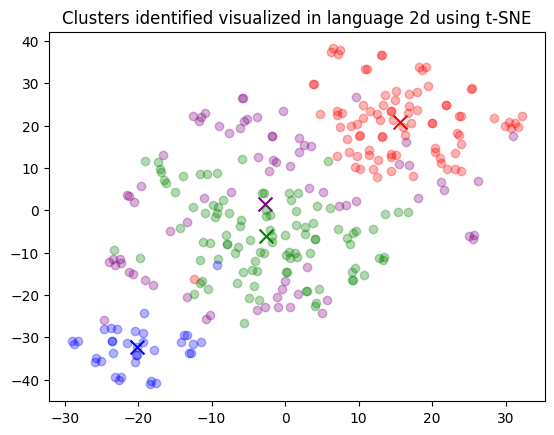

In [18]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


In [19]:
import openai

# Reading a review which belong to each group.
rev_per_cluster = 5

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = "\n".join(
        df[df.Cluster == i]
        .combined.str.replace("Title: ", "")
        .str.replace("\n\nContent: ", ":  ")
        .sample(rev_per_cluster, random_state=42)
        .values
    )
    response = openai.Completion.create(
        model="davinci-002",
        prompt=f'What do the following customer reviews have in common?\n\nCustomer reviews:\n"""\n{reviews}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))

    sample_cluster_rows = df[df.Cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.Score.values[j], end=", ")
        print(sample_cluster_rows.Summary.values[j], end=":   ")
        print(sample_cluster_rows.Text.str[:70].values[j])

    print("-" * 100)


Cluster 0 Theme:  "barbeque sauce" (1)- 1. Barbeque Sauce- 2. Barbeque Sauce- 3. Barbeque Sauce- 4. Barbeque Sauce- 5. Barbeque Sauce- 6. Barbeque Sauce-
5, Belongs in your kitchen:   Grapeseed oil is a healthy, light oil of very mild but pleasing flavor
4, Its LIGHT but very nice sweetener:   This Nectresse Sweetener is rather light in taste --but is very nice o
5, ZipFizz liquid energy shot:   Have used this for years.  Gives long lasting energy boost with no sud
1, Couldn't tell you how it tasted:   The bottle was not sealed, and when I opened the cover, there was blac
5, no complaints:   I'm a huge fan of Jack Daniel's jelly, <a href="http://www.amazon.com/
----------------------------------------------------------------------------------------------------
Cluster 1 Theme:  "The best breakfast cereal" by "The best breakfast cereal" by "The best breakfast cereal" by "The best breakfast cereal" by "The best breakfast cereal" by "The best breakfast cereal" by "The best breakfast cerea